# Data Investigation File - Trenton Squires 661961306

# Loads all of the same modules used in the main file, and configures the computers GPU

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
import numpy as np
import datetime

from scipy import signal

import matplotlib.pyplot as plt

# Using GPU for Tensorflow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
cpus = tf.config.experimental.list_physical_devices(device_type="CPU")
print(gpus)
try:
    tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=6144)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except:
    tf.config.set_logical_device_configuration(cpus[0])

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


# Loads, filters, and formats data in the same way the learning file does

In [2]:
ECG_leads = ['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']

signals = [0,1,2,3,4,5,6,7,8,9,10,11]
# signals = [1,2,9]
# signals = [1]

trainSignalList = []
testSignalList = []
for i in signals:
    signal_train = pd.read_parquet('data/train/signals/signal{}_train.parquet'.format(i))['signal'].tolist()
    trainSignalList.append(signal_train)
    signal_test = pd.read_parquet('data/test/signals/signal{}_test.parquet'.format(i))['signal'].tolist()
    testSignalList.append(signal_test)

X_train = np.stack(trainSignalList, axis=1)
X_test = np.stack(testSignalList, axis=1)
print(X_train.shape)
print(X_test.shape)

diagnostic_superclass_train = pd.read_parquet('data/train/diagnostic_superclass_train.parquet')

diagnostic_superclass_test = pd.read_parquet('data/test/diagnostic_superclass_test.parquet')

y_train = diagnostic_superclass_train['diagnostic_superclass']
y_test = diagnostic_superclass_test['diagnostic_superclass']

label_dict = {'NORM': 0, 'MI': 1, 'STTC': 2, 'CD': 3, 'HYP': 4}

def makeBinary(y):
    y_int = np.zeros([y.shape[0], 1])
    i = 0
    for label in y:
        array = np.zeros(5,dtype=int)
        if np.any(label == 'NORM'):
            array[0] = 1
        if np.any(label == 'MI'):
            array[1] = 1
        if np.any(label == 'STTC'):
            array[2] = 1
        if np.any(label == 'CD'):
            array[3] = 1
        if np.any(label == 'HYP'):
            array[4] = 1
        res = int("".join(map(str, array)))
        y_int[i]=int(str(res),2)
        i+=1
    return y_int

y_train_int = makeBinary(y_train)
y_test_int = makeBinary(y_test)

y_train_categorical = to_categorical(y_train_int,num_classes=31)
y_test_categorical = to_categorical(y_test_int,num_classes=31)
print(set(y_train_int.flatten()))

# import pdb; pdb.set_trace()

def filterData(X,highpass = True,lowpass = True):
    if highpass:

        fs = 100.0  # Sampling frequency
        fc = 1.0    # Cutoff frequency for high-pass filter

        b, a = signal.butter(4, fc / (fs / 2), 'highpass')

        for ecg in range(X.shape[0]):
            for lead in range(X.shape[1]):
                # Apply filter to ECG data
                X[ecg,lead,:] = signal.filtfilt(b, a, X[ecg,lead,:])
    if lowpass:

        fs = 100.0  # Sampling frequency
        fc = 30.0   # Cutoff frequency for low-pass filter

        b, a = signal.butter(4, fc / (fs / 2), 'lowpass')

        for ecg in range(X.shape[0]):
            for lead in range(X.shape[1]):
                # Apply filter to ECG data
                X[ecg,lead,:] = signal.filtfilt(b, a, X[ecg,lead,:])
    return X

X_train_filtered = filterData(X_train.copy())
X_test_filtered = filterData(X_test.copy())
print("Filtered")

(19601, 12, 1000)
(2198, 12, 1000)
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 20.0, 22.0, 27.0}
Filtered


# Code to show filtered and unfiltered ECG data from a specified lead and test patient

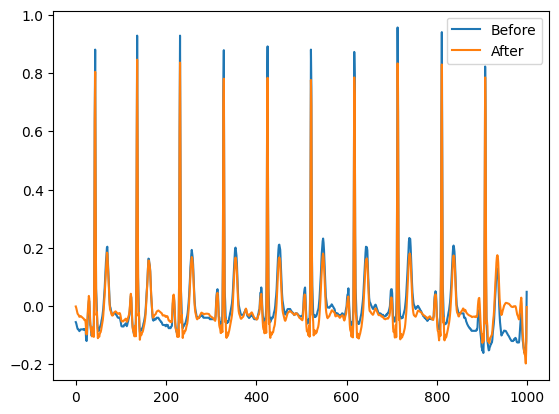

In [3]:
patient = 20
lead = 1
plt.plot(X_test[patient,lead,:])
plt.plot(X_test_filtered[patient,lead,:])
plt.legend(["Before", "After"])

# Function to convert decimal formatted targets back to list formatted targets

In [4]:
def reverse_target(decimal_num):
    binary_str = np.binary_repr(decimal_num, width=5)
    class_labels = ["NORM", "MI", "STTC", "CD", "HYP"]
    target = []
    for i in range(len(binary_str)):
        if binary_str[i] == '1':
            target.append(class_labels[i])
    return target

# Loads specified model

In [5]:
model = load_model('Model_20230419-154715') #5 epochs 12 leads
# model = load_model('Model_20230419-165151') #25 epochs 12 leads

# Code used to investigate model's performance using a probability bar chart

1/1 [==============================] - 4s 4s/step


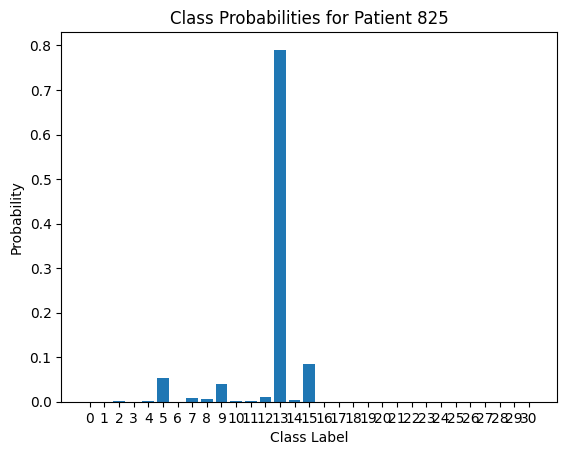

The most likely diagnosis from the model is [13]
This means: ['MI', 'STTC', 'HYP']
Real Diagnosis is [13.]
This means: ['MI', 'STTC', 'HYP']


Text(0.5, 1.0, "Test Patient 825 ECG Lead II Signal, Model Diagnosis = ['MI', 'STTC', 'HYP']")

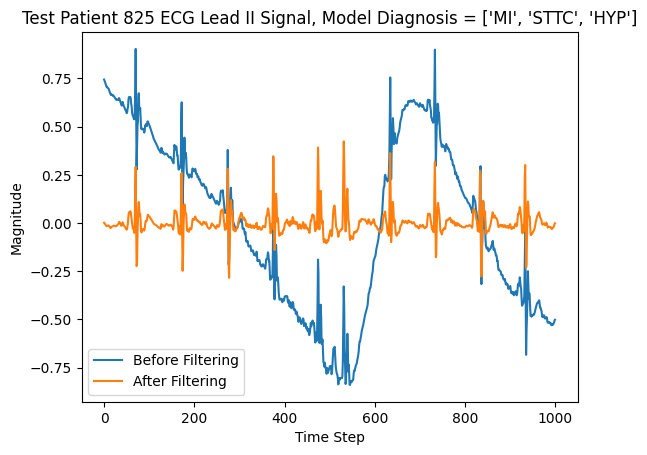

In [6]:
# Define the class labels as a list of strings
class_labels = [str(i) for i in range(0, 31)]

# Get the predicted class probabilities for the patient's ECG signal
patient = 825
input_data = X_test[patient][np.newaxis, ...]
output = model.predict(input_data)
predicted_class = np.argmax(output, axis=1)
probs = output[0]

plt.bar(class_labels, probs)
plt.xlabel('Class Label')
plt.ylabel('Probability')
plt.title('Class Probabilities for Patient {}'.format(patient))
plt.show()
print("The most likely diagnosis from the model is", predicted_class)
print("This means:", reverse_target(predicted_class[0]))
print("Real Diagnosis is", y_test_int[patient])
print("This means:", reverse_target(int(y_test_int[patient][0])))

lead = 1
plt.plot(X_train[patient,lead,:])
plt.plot(X_train_filtered[patient,lead,:])
plt.legend(["Before Filtering", "After Filtering"])
plt.xlabel('Time Step')
plt.ylabel('Magnitude')
plt.title('Test Patient {} ECG Lead {} Signal, Model Diagnosis = {}'.format(patient, ECG_leads[lead], reverse_target(predicted_class[0])))# plt.show()

# Below used to check what each decimal class label actually means

In [7]:
print(reverse_target(3))

['CD', 'HYP']


# Different ECG signal graph formatting, with the diagnosis string in the title

Text(0.5, 1.0, 'Test Patient 2097 ECG Lead II Signal, Real Diagnosis = []')

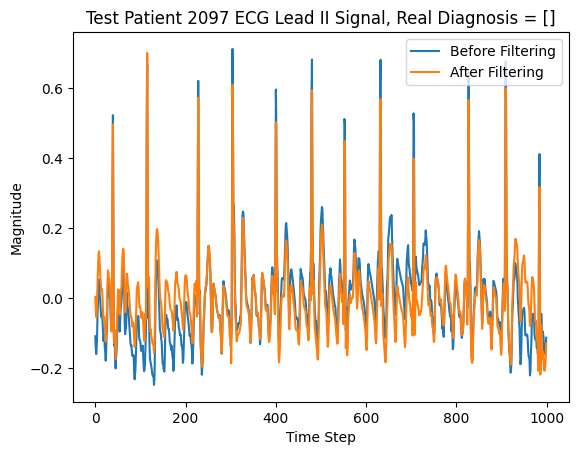

In [8]:
patient = 2097
lead = 1
plt.plot(X_train[patient,lead,:])
plt.plot(X_train_filtered[patient,lead,:])
plt.legend(["Before Filtering", "After Filtering"])
plt.xlabel('Time Step')
plt.ylabel('Magnitude')
plt.title('Test Patient {} ECG Lead {} Signal, Real Diagnosis = {}'.format(patient, ECG_leads[lead], reverse_target(int(y_test_int[patient][0]))))

# Code below used to find the indices where a certain classification exists for the real test data

In [9]:
for i in range(y_test_int.size):
    if y_test_int[i] == 16:
        print(i)

0
1
2
3
4
7
8
9
10
11
12
13
15
16
17
18
20
21
29
30
31
35
36
37
38
43
46
47
52
54
55
58
62
63
66
73
76
79
80
82
84
87
89
90
94
95
97
98
100
101
103
105
108
111
112
113
114
115
117
120
122
123
131
132
133
134
136
138
139
141
142
143
144
146
147
149
150
151
152
154
155
159
160
161
164
165
166
168
169
172
173
174
186
187
188
190
191
192
193
199
200
201
203
204
205
206
207
208
209
210
214
216
219
221
222
224
227
228
229
230
231
233
234
236
237
238
239
242
243
246
248
250
251
252
257
261
267
271
275
276
277
281
282
284
286
287
288
291
294
298
300
302
305
307
308
312
316
317
319
320
322
324
327
329
333
336
343
344
346
350
353
354
355
356
357
359
360
361
362
363
364
367
370
371
372
373
375
376
377
379
380
381
382
383
384
386
387
390
392
393
396
397
398
400
401
402
403
404
405
410
421
425
429
430
431
432
438
439
440
442
443
444
445
447
452
460
461
462
465
468
469
471
472
478
479
481
485
493
498
499
501
503
507
508
510
511
516
517
520
521
522
525
526
527
528
529
530
539
542
544
546
550
551
554


# Test Accuracy and Test Loss Calculation

In [10]:
test_loss, test_acc = model.evaluate(X_test_filtered,y_test_categorical, verbose=0)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

Test Accuracy: 0.6105550527572632
Test Loss: 1.2173861265182495


# Code below used to find the indices where a certain classification exists for the model

In [11]:
for i in range(y_test_int.size):
    input_data = X_test[i][np.newaxis, ...]
    output = model.predict(input_data, verbose = 0)
    predicted_class = np.argmax(output, axis=1)
    if predicted_class[0] == 16:
        print(i)

0
1
2
3
4
5
8
10
11
12
13
15
16
17
18
20
25
30
31
32
33
35
36
38
46
48
49
52
54
55
58
63
66
73
76
79
80
82
85
87
89
90
94
95
97
98
100
101
104
105
108
110
111
113
114
115
116
117
122
131
132
133
134
136
138
141
142
143
144
147
150
151
157
159
161
162
164
166
168
171
172
174
176
180
184
187
188
191
192
193
194
200
201
203
204
205
207
208
209
210
214
215
216
219
221
222
223
224
227
228
230
233
234
236
237
238
239
240
242
243
246
248
250
257
261
267
271
275
276
277
281
282
284
286
287
288
298
300
301
303
305
307
308
312
314
316
317
319
322
324
327
328
329
330
333
336
340
343
344
346
350
354
355
356
357
359
362
363
364
367
369
371
372
373
375
376
378
379
382
383
384
387
390
392
396
397
398
400
401
402
403
404
405
410
413
418
425
429
431
432
438
439
440
442
444
447
450
452
454
460
461
462
463
465
468
469
471
473
478
479
485
496
503
507
510
511
516
517
520
521
522
527
528
529
533
544
546
550
551
554
559
564
572
575
580
583
593
594
595
602
614
617
622
625
630
632
636
638
639
641
646
647
652
6

# Code below used to calculate the percentage of guesses where the model guessed at least one class in the real diagnosis.

In [12]:
def check_match(list1, list2):
    for str1 in list1:
        for str2 in list2:
            if str1 == str2:
                return True
    return False

num_one_match = 0
for i in range(y_test_int.size):
    input_data = X_test[i][np.newaxis, ...]
    output = model.predict(input_data, verbose = 0)
    predicted_class = np.argmax(output, axis=1)
    realList = reverse_target(int(predicted_class[0]))
    modelList = reverse_target(int(y_test_int[i][0]))
    if check_match(realList, modelList):
        num_one_match += 1
        
print("Percentage of guesses where the model guessed at least one class in the real diagnosis =", round(num_one_match/y_test_int.size,2))

Percentage of guesses where the model guessed at least one class in the real diagnosis = 0.76


# Code below used to calculate the percentage of guesses where the model's normal diagnosis was correct.

In [13]:
num_norm_match = 0
num_norm_real = 0
for i in range(y_test_int.size):
    input_data = X_test[i][np.newaxis, ...]
    output = model.predict(input_data, verbose = 0)
    predicted_class = np.argmax(output, axis=1)
    realList = reverse_target(int(predicted_class[0]))
    if realList == ['NORM']:
        num_norm_real += 1
        modelList = reverse_target(int(y_test_int[i][0]))
        if realList == modelList:
            num_norm_match += 1
        
print("Percentage of guesses where the model's normal diagnosis was correct =", round(num_norm_match/num_norm_real,2))

Percentage of guesses where the model's normal diagnosis was correct = 0.82


In [14]:
def check_match(list1, list2):
    for str1 in list1:
        for str2 in list2:
            if str1 == str2:
                return True
    return False

num_condition_match = 0
num_condition_real = 0
for i in range(y_test_int.size):
    input_data = X_test[i][np.newaxis, ...]
    output = model.predict(input_data, verbose = 0)
    predicted_class = np.argmax(output, axis=1)
    realList = reverse_target(int(predicted_class[0]))
    if check_match(realList, ["MI", "STTC", "CD", "HYP"]):
        # if the patient has any condition:
        num_condition_real += 1
        modelList = reverse_target(int(y_test_int[i][0]))
        if check_match(modelList, ["MI", "STTC", "CD", "HYP"]):
            # if the model predicts the patient has any condition
            num_condition_match += 1
        
print("Percentage of guesses where the model correctly guessed that there is something wrong with the patient, even if it is the wrong diagnosis: ", round(num_condition_match/num_condition_real,2))

Percentage of guesses where the model correctly guessed that there is something wrong with the patient, even if it is the wrong diagnosis:  0.81
